In [1]:
import os
import cv2
import seaborn as sn 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import glob as glob
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.applications.vgg19 import VGG19
from keras.applications import Xception
from keras.applications import ResNet50V2
from keras.applications import ResNet101
from keras.applications import ResNet152
from keras.applications import InceptionV3

In [2]:
color = 'rgb' #'grayscale' o 'rgb'

escala = 150

In [3]:
def cargar_datos(path1, path2, escala = escala, color = color):
    
    EMD = os.listdir(path1)
    NO_EMD = os.listdir(path2)
    
    data = []
    labels = []

    for i in EMD:   
        image=tf.keras.preprocessing.image.load_img(path1+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(1)
    for i in NO_EMD:   
        image=tf.keras.preprocessing.image.load_img(path2+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(0)
        
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

In [4]:
dataset_iphone = cargar_datos('Datos preprocesados INP EMD/iPhone/EMD', 'Datos preprocesados INP EMD/iPhone/NO EMD')

dataset_samsung = cargar_datos('Datos preprocesados INP EMD/Samsung/EMD', 'Datos preprocesados INP EMD/Samsung/NO EMD')

dataset = cargar_datos('Datos preprocesados INP EMD/OCT/EMD', 'Datos preprocesados INP EMD/OCT/NO EMD')

In [7]:
def trasnferLearning_classweight(test, red):
    
    #Definir conjuntos de datos train y test
    
    if test=='iphone':
        
        train_ds = np.concatenate((dataset[0],dataset_samsung[0]))
        train_labels = np.concatenate((dataset[1],dataset_samsung[1]))
        
        test_ds = dataset_iphone[0]
        test_labels = dataset_iphone[1]
        
    elif test=='samsung':
        
        train_ds = np.concatenate((dataset[0],dataset_iphone[0]))
        train_labels = np.concatenate((dataset[1],dataset_iphone[1]))

        test_ds = dataset_samsung[0]
        test_labels = dataset_samsung[1]
    
    train_labels_categorical = to_categorical(train_labels, num_classes=2)
    test_labels_categorical = to_categorical(test_labels, num_classes=2)
    
    #Definir modelo de trasnfer learning
    base_model = red(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
    base_model.trainable = False ## Not trainable weights

    #Preprocessing input
    train_ds = preprocess_input(train_ds) 
    test_ds = preprocess_input(test_ds)
    
    #Definir fine tunning
    flatten_layer = layers.Flatten()
    dense_layer_1 = layers.Dense(50, activation='relu')
    dense_layer_2 = layers.Dense(20, activation='relu')
    prediction_layer = layers.Dense(2, activation='softmax')


    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer_1,
        dense_layer_2,
        prediction_layer
    ])
    
    #Definir compensador de pesos
    classes = np.unique(train_labels)
    class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=train_labels)
    dic_class_weights = {0:class_weights[0], 1:class_weights[1]}
    
    #Entrenar el modelo
    model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

    es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

    history = model.fit(train_ds, train_labels_categorical, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es], class_weight=dic_class_weights)
    
    #Métricas de evaluación
    score_test = model.evaluate(x=test_ds, y=test_labels_categorical, verbose = 0)
    print("Test loss:", score_test[0])
    print("Test accuracy:", score_test[1])
    
    predictions = model.predict(test_ds)
    roc_score = roc_auc_score(test_labels_categorical, predictions, multi_class='ovr')
    print("AUC score:", roc_score)
    
    labels_predict = []
    for e in predictions:
        if e[0]>e[1]:
            labels_predict.append(0)
        else:
            labels_predict.append(1)
        
    f1 = f1_score(test_labels, labels_predict, average='weighted')
    print("f1-score", f1)
    
    matriz = confusion_matrix(test_labels, labels_predict)
    print("Matriz de confusión", matriz)
    
    return history

## VGG16

In [8]:
history_vgg16 = trasnferLearning_classweight('iphone', VGG16)

Epoch 1/200
6/6 [==============================] - 10s 1s/step - loss: 5.2753 - accuracy: 0.5976 - val_loss: 25.5167 - val_accuracy: 0.0238
Epoch 2/200
6/6 [==============================] - 8s 1s/step - loss: 3.8079 - accuracy: 0.6159 - val_loss: 24.6800 - val_accuracy: 0.0476
Epoch 3/200
6/6 [==============================] - 9s 2s/step - loss: 4.4854 - accuracy: 0.8293 - val_loss: 13.2214 - val_accuracy: 0.1905
Epoch 4/200
6/6 [==============================] - 10s 2s/step - loss: 1.0015 - accuracy: 0.7622 - val_loss: 1.3726 - val_accuracy: 0.8095
Epoch 5/200
6/6 [==============================] - 11s 2s/step - loss: 0.9113 - accuracy: 0.8537 - val_loss: 13.4851 - val_accuracy: 0.0000e+00
Epoch 6/200
6/6 [==============================] - 10s 2s/step - loss: 0.2479 - accuracy: 0.9329 - val_loss: 7.4764 - val_accuracy: 0.3333
Epoch 7/200
6/6 [==============================] - 10s 2s/step - loss: 0.4746 - accuracy: 0.8902 - val_loss: 18.3599 - val_accuracy: 0.0000e+00
Epoch 8/200
6/6 

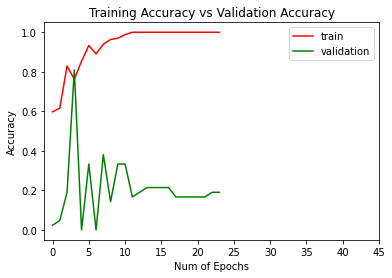

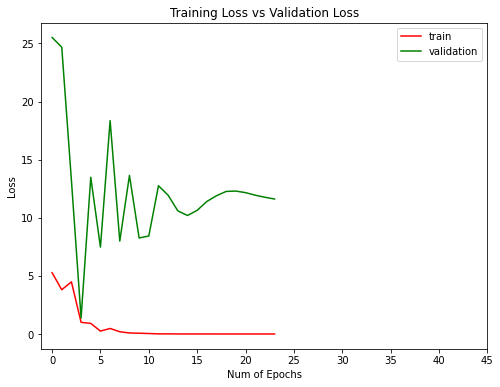

In [9]:
plt.figure(0)  
plt.plot(history_vgg16.history['accuracy'],'r')  
plt.plot(history_vgg16.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_vgg16.history['loss'],'r')  
plt.plot(history_vgg16.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

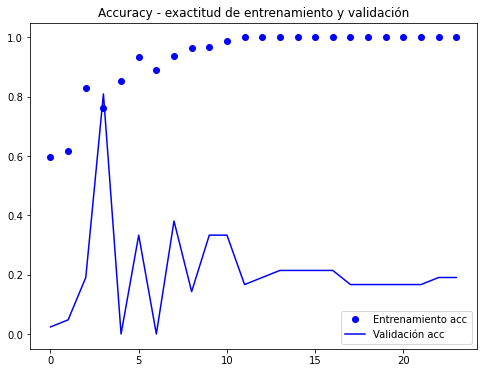

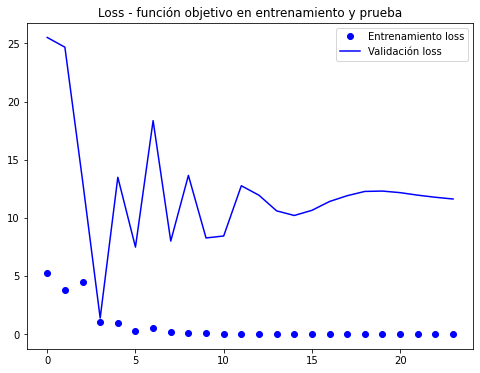

In [10]:
acc      = history_vgg16.history['accuracy']
val_acc  = history_vgg16.history['val_accuracy']
loss     = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()